## randomized functions

In [1]:
import numpy as np

In [2]:
class randomize_image():
    
    def __init__(self):
        img_size = 28 * 28
        self.shuffle_idx = np.arange(img_size)
        self.shuffle()
        
    def process_img(self, img):
        assert len(img.size()) == 3
        assert img.size(0) == 3
        img = img.view(3, -1)
        # print(self.shuffle_idx[:10])
        img = img[:,self.shuffle_idx]
        # print(img.size())
        img = img.view(3,28,28)
        return img
        
    def shuffle(self):
        np.random.shuffle(self.shuffle_idx)



def standardize_imgs(imgs):
    assert len(imgs.size()) == 4
    for i in range(imgs.size(0)):
        tmp = imgs[i].view(3, -1)
        tmp_mean = tmp.mean(dim=1).numpy()
        tmp_var = np.maximum(tmp.std(dim=1).numpy(), 1.0 / 28.0 / 28.0)

        imgs[i] = (imgs[i] - torch.FloatTensor(tmp_mean).view(3, 1, 1)) / torch.FloatTensor(tmp_var).view(3,1,1)
    return imgs

## resnet

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

## import cifar 10 dataset

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset

In [5]:
class MyDataset(Dataset):

    def __init__(self, dataset, pixel_mode, label_mode, num_classes):
        self.randomizer = randomize_image()
        self.pixel_mode = pixel_mode
        self.label_mode = label_mode
        self.num_classes = num_classes
        self.create_dataset(dataset)
        
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        return self.imgs[idx], self.labels[idx]
    
    def create_dataset(self, dataset):
        self.imgs = []
        self.labels = []
        
        for img, label in dataset:
            if self.pixel_mode == "random_pixel":
                img = self.randomized_img(img)
            elif self.pixel_mode == "shuffle_pixel":
                img = self.randomized_img(img, random=False)
            elif self.pixel_mode == "gaussian_pixel":
                img = self.gaussian_img(img)
            elif self.pixel_mode == "true_pixel":
                pass
            else:
                raise ValueError("wrong pixel mode")

            if self.label_mode == "random_label":
                label = self.randomized_label(label, self.num_classes)
                # print(label)
            elif self.label_mode == "true_label":
                pass
            else:
                raise ValueError("wrong label mode") 
            self.imgs.append(img)
            self.labels.append(label)

    def randomized_img(self, img, random = True):
       
        if random:
            self.randomizer.shuffle()
        img = self.randomizer.process_img(img)
        return img

    def gaussian_img(self, img):
        assert len(img.shape) == 3
        
        tmp = img.view(3,-1)
        tmp_mean = tmp.mean(dim=1).numpy()
        tmp_var = tmp.std(dim=1).numpy()
        tmp_img = np.random.multivariate_normal(tmp_mean, np.diag(tmp_var), size = (28,28))
        img = torch.FloatTensor(tmp_img).transpose(0,2)

        return img
    
    
    def randomized_label(self, label, num_classes):
        
        return np.random.randint(num_classes, size=1)





In [6]:

# optimizer = optim.SGD(net.parameters(),lr=0.01, momentum=0.9)

def train(epoch, starting_step, loss_list):
    # print("\nepoch %d" %epoch)
    
    total_loss = 0
    total_samples = 0
    total_corrects = 0
#     print("starting_step is ",starting_step)
    for i, (imgs, labels) in enumerate(trainloader):
        imgs = standardize_imgs(imgs)

        if use_cuda:
            imgs = Variable(imgs).cuda()
            labels = Variable(labels).squeeze().cuda()
        else:
            imgs = Variable(imgs)
            labels = Variable(labels).squeeze()
            
        logits = net(imgs)

        step_loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        step_loss.backward()
        optimizer.step()       
        
        batch_size = logits.size(0)
        _, preds = torch.max(logits, 1)
        total_samples += batch_size
        step_corrects = torch.sum(preds.data == labels.data)
        total_corrects += step_corrects
        total_loss += step_loss.data
        
        step_acc = step_corrects * 1. / batch_size
        
        total_acc = total_corrects * 1.0 / total_samples
        
        if (starting_step + i) % 1000 == 0: 
            l = predict(starting_step + i, "train")
            loss_list.append(l.cpu().numpy()[0])
            # predict(starting_step + i, "test")
            # print("step %d, %d_acc %f, %s_loss %f" %(starting_step + i, mode, total_acc, mode, total_loss  / total_samples ))
            # test(starting_step + i)
            
            
    return  starting_step + i

def predict(step, mode):
    
    if mode == "train":
        dataloader = trainloader
    elif mode == "test":
        dataloader = testloader
  
    total_loss = 0
    total_samples = 0
    total_corrects = 0
#     print("starting_step is ",starting_step)
    for i, (imgs, labels) in enumerate(dataloader):
        imgs = standardize_imgs(imgs)

        if use_cuda:
            imgs = Variable(imgs).cuda()
            labels = Variable(labels).squeeze().cuda()
        else:
            imgs = Variable(imgs)
            labels = Variable(labels).squeeze()
            
        logits = net(imgs)
        step_loss = criterion(logits, labels)
             
        batch_size = logits.size(0)
        _, preds = torch.max(logits, 1)
        total_samples += batch_size
        step_corrects = torch.sum(preds.data == labels.data)
        total_corrects += step_corrects
        
        total_loss += step_loss.data
        
    total_acc = total_corrects * 1.0 / total_samples
    total_loss = total_loss  / total_samples    
        
    print("step %d: %s_acc %f, %s_loss %f" %(step, mode, total_acc, mode, total_loss))
    return total_loss

        
    

In [10]:
result = {}
gpu = '0'

In [12]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

combinations = {0 : ("random_pixel", "true_label"), 1 : ("shuffle_pixel", "true_label"), 
                2 : ("gaussian_pixel", "true_label"), 
                3 : ("true_pixel", "random_label"), 
                4 : ("true_pixel", "true_label")
                }

# combinations = {0 : ("random_pixel", "true_label")}

# result = {}
for key, (pixel_mode, label_mode) in combinations.items():
       
    
    result[key] = []
    transform = transforms.Compose(
        [transforms.CenterCrop(28),
         transforms.ToTensor()
         ])

#     pixel_mode = "true_pixel"
#     label_mode = "true_label"

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    mytrainset = MyDataset(trainset, pixel_mode, label_mode, num_classes)
    trainloader = torch.utils.data.DataLoader(mytrainset, batch_size=40,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    mytestset = MyDataset(testset, pixel_mode, label_mode, num_classes)
    testloader = torch.utils.data.DataLoader(mytestset, batch_size=40,
                                             shuffle=False, num_workers=2)


    net = ResNet18()
    use_cuda = True

    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu

    if use_cuda:
        net = net.cuda()
        
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(),lr=0.001)
    optimizer = optim.SGD(net.parameters(),lr=0.001, momentum=0.9)
    
    print("paramters now are {} and {}".format(pixel_mode, label_mode))

    starting_step = 0
    for epoch in range(25):
        total_step = train(epoch, starting_step, result[key])
        # print("total step for now is ", total_step)
        starting_step  = total_step + 1

Files already downloaded and verified
Files already downloaded and verified
paramters now are random_pixel and true_label
step 0: train_acc 0.100640, train_loss 0.057959
step 1000: train_acc 0.225800, train_loss 0.052404
step 2000: train_acc 0.265260, train_loss 0.050093
step 3000: train_acc 0.320080, train_loss 0.047531
step 4000: train_acc 0.360900, train_loss 0.045104
step 5000: train_acc 0.394620, train_loss 0.043440
step 6000: train_acc 0.471560, train_loss 0.039754
step 7000: train_acc 0.526260, train_loss 0.035969
step 8000: train_acc 0.583580, train_loss 0.031578
step 9000: train_acc 0.679820, train_loss 0.023777
step 10000: train_acc 0.715020, train_loss 0.022921
step 11000: train_acc 0.757740, train_loss 0.019023
step 12000: train_acc 0.785720, train_loss 0.016005
step 13000: train_acc 0.878120, train_loss 0.009350
step 14000: train_acc 0.915880, train_loss 0.006778
step 15000: train_acc 0.902360, train_loss 0.007507
step 16000: train_acc 0.938160, train_loss 0.004920
step 17

In [13]:
result

{0: [0.05795902,
  0.052404266,
  0.050093383,
  0.04753148,
  0.045104105,
  0.0434402,
  0.039753873,
  0.035969347,
  0.031577896,
  0.023776794,
  0.022921344,
  0.019023169,
  0.016004786,
  0.009350176,
  0.006777805,
  0.0075065345,
  0.0049199155,
  0.00380011,
  0.0025800942,
  0.002463327,
  0.002175527,
  0.0014782981,
  0.0008988571,
  0.00059917325,
  0.00046303766,
  0.00027695252,
  0.00015620209,
  8.688359e-05,
  6.243775e-05,
  4.1307878e-05,
  3.2471908e-05,
  2.9241135e-05],
 2: [0.059018366]}

In [14]:
with open("result_{}.pkl".format(gpu), 'wb') as f:
    import pickle
    pickle.dump(result, f)

In [30]:
losses = {}
for i in range(5):
    import pickle
    with open("result_{}.pkl".format(i), 'rb') as f:
        losses[i] = pickle.load(f)[i]

In [31]:
losses

{0: [0.05795902,
  0.052404266,
  0.050093383,
  0.04753148,
  0.045104105,
  0.0434402,
  0.039753873,
  0.035969347,
  0.031577896,
  0.023776794,
  0.022921344,
  0.019023169,
  0.016004786,
  0.009350176,
  0.006777805,
  0.0075065345,
  0.0049199155,
  0.00380011,
  0.0025800942,
  0.002463327,
  0.002175527,
  0.0014782981,
  0.0008988571,
  0.00059917325,
  0.00046303766,
  0.00027695252,
  0.00015620209,
  8.688359e-05,
  6.243775e-05,
  4.1307878e-05,
  3.2471908e-05,
  2.9241135e-05],
 1: [0.05825297,
  0.039379593,
  0.033480138,
  0.02868439,
  0.022843085,
  0.02005217,
  0.017662708,
  0.013809802,
  0.009858857,
  0.0073062317,
  0.007423449,
  0.005983777,
  0.003927942,
  0.0030667107,
  0.0028582583,
  0.002696125,
  0.002050309,
  0.0014030677,
  0.0011149845,
  0.0011740539,
  0.00085914845,
  0.000767975,
  0.0007131373,
  0.00049806637,
  0.0004939601,
  0.00042798702,
  0.00023723561,
  0.00013876709,
  6.721553e-05,
  5.0285144e-05,
  3.494404e-05,
  2.8087648e-

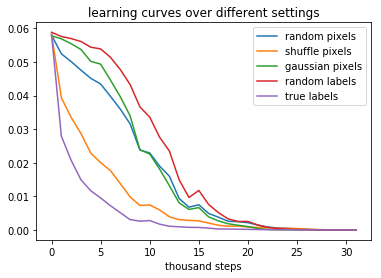

In [33]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

x = np.arange(32)
for i in range(5):
    plt.plot(x, losses[i])
plt.legend([ "random pixels", "shuffle pixels", "gaussian pixels", "random labels", "true labels" ], loc='upper right')
plt.xlabel(r"thousand steps")
plt.title('learning curves over different settings')
plt.show()